In [2]:
# install dependencies
#!/usr/bin/env python3
from pathlib import Path
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Read data
data = pd.read_csv("../Data/combined_admissions_characteristics.csv")

C:\Users\ceero\AppData\Local\Temp\ipykernel_26000\4005158022.py:2: DtypeWarning: Columns (56,58,72,74,80,82,84,86,88,90,92,94,96,98,100,102,104,106,108,121,147,184,185,198) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/combined_admissions_characteristics.csv")


In [4]:
# create required (1) and recommended (2 or 5) indicator columns for each ADMCON column
cols = ['ADMCON1', 'ADMCON2', 'ADMCON3', 'ADMCON4', 'ADMCON5', 'ADMCON6', 'ADMCON7', 'ADMCON8', 'ADMCON9']

for c in cols:
    if c not in data.columns:
        print(f"Warning: column {c} not found in dataframe")
        continue
    data[f'{c}_required'] = (data[c] == 1).astype(int)
    data[f'{c}_recommended'] = data[c].isin([2, 5]).astype(int)

In [5]:
# Create post_covid indicator column
data['post_covid'] = (data['year'] >= 2020).astype(int)

In [6]:
# Create columns for the CONTROL categorical variable
# Make booleans for each value of CONTROL
data['CONTROL'] = data['CONTROL'].astype('category')
for val in data['CONTROL'].cat.categories:
    data[f'CONTROL_{val}'] = (data['CONTROL'] == val).astype(int)

In [7]:
# Run logistic regressions for every ADMCON *_required and *_recommended variable
import warnings
warnings.filterwarnings('ignore')

# collect target columns
target_cols = [c for c in data.columns if c.endswith('_required') or c.endswith('_recommended')]
if not target_cols:
    raise ValueError('No target columns ending with _required or _recommended found in `data`.')

results_index = []
for ycol in target_cols:
    print('\n' + '='*80)
    print(f"Running logit for outcome: {ycol}")

    y = data[ycol]

    # Basic independent variables
    requested_controls = ['post_covid', 'year']
    # Levels of the CONTROL categorical variable
    requested_controls.extend([f'CONTROL_{val}' for val in data['CONTROL'].cat.categories])
    requested_controls.remove('CONTROL_1') # avoid dummy variable trap
    present = [c for c in requested_controls if c in data.columns]
    missing = [c for c in requested_controls if c not in data.columns]
    if missing:
        print(f"Warning: these requested columns are missing and will be omitted: {missing}")

        if not present:
            print(f"Skipping {ycol}: no predictor columns available after checking presence.")
            continue

    # prepare X, convert non-numeric categorical controls to dummies
    X_df = data[present].copy()
    for col in present:
        if not np.issubdtype(X_df[col].dtype, np.number):
            dummies = pd.get_dummies(X_df[col], prefix=col, drop_first=True)
            X_df = X_df.drop(columns=col).join(dummies)

    X = sm.add_constant(X_df)

    # drop rows with missing values on y or X
    mask_logit = y.notna() & X.notna().all(axis=1)
    y_clean_logit = y[mask_logit]
    X_clean_logit = X.loc[mask_logit]

    # fit logit, handle potential convergence/separation issues
    try:
        logit_res = sm.Logit(y_clean_logit, X_clean_logit).fit(disp=False, maxiter=200)
    except Exception as e:
        print("Logit failed with default solver:", e)
        print("Retrying with 'bfgs'...")
        logit_res = sm.Logit(y_clean_logit, X_clean_logit).fit(disp=False, method='bfgs', maxiter=200)

    print(logit_res.summary())
    # export the summary table to a latex file per outcome
    safe_name = ycol.replace('/', '_')
    try:
        with open(f"../Output/logit_summary_{safe_name}.tex", "w") as f:
            f.write(logit_res.summary().as_latex())
    except Exception as e:
        print(f"Warning: failed to write LaTeX summary for {ycol}: {e}")

    # save predicted probabilities to the dataframe
    data[f'{ycol}_logit_pred'] = np.nan
    data.loc[mask_logit, f'{ycol}_logit_pred'] = logit_res.predict(X_clean_logit)

    # report pseudo R-squared and RMSE of probability predictions
    prsquared = getattr(logit_res, 'prsquared', None)
    rmse_logit = np.sqrt(((y_clean_logit - logit_res.predict(X_clean_logit)) ** 2).mean())
    print(f"Pseudo R-squared (McFadden): {prsquared}")
    print(f"RMSE (probabilities): {rmse_logit:.6f}")


Running logit for outcome: ADMCON1_required
                           Logit Regression Results                           
Dep. Variable:       ADMCON1_required   No. Observations:                20575
Model:                          Logit   Df Residuals:                    20570
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Oct 2025   Pseudo R-squ.:                 0.07457
Time:                        18:18:35   Log-Likelihood:                -10735.
converged:                       True   LL-Null:                       -11600.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -94.6028     22.450     -4.214      0.000    -138.605     -50.601
post_covid    -0.0800      0.067     -1.197      0.231      -0.211       0.051
year   

<module 'matplotlib.pyplot' from 'c:\\Users\\ceero\\anaconda3\\envs\\myenv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

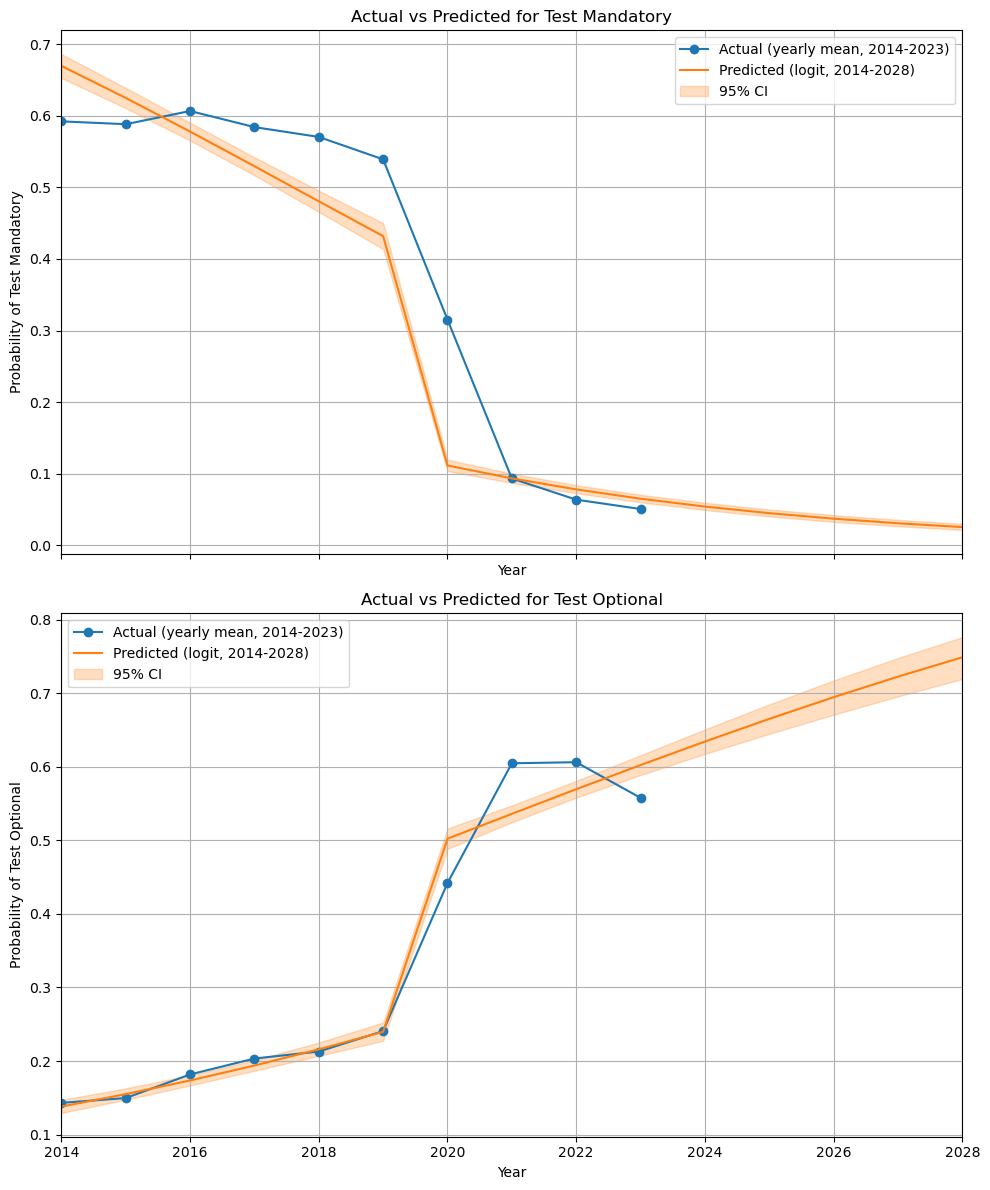

In [8]:
# Predict and plot actual (2014-2023) vs predicted (2014-2028) for ADMCON7_required and ADMCON7_recommended
outcomes = ['ADMCON7_required', 'ADMCON7_recommended']
yrs_actual = np.arange(2014, 2024)  # 2014-2023
yrs_pred = np.arange(2014, 2029)  # 2014-2028 (max_year is 2023 in notebook)

# Ensure we have the exogenous names (including 'const') and the baseline controls to set for prediction
exog = ['const','post_covid','year','CONTROL_2','CONTROL_3']
controls = [c for c in exog if c not in ('const', 'post_covid', 'year')]

# Build a prediction DataFrame for the prediction range using sample means for control dummies
control_means = data[controls].mean()
pred_base = pd.DataFrame({
    'year': yrs_pred,
    'post_covid': (yrs_pred >= 2020).astype(int)
})
for c in controls:
    pred_base[c] = control_means[c]
# add const and reorder to match exog
pred_X = sm.add_constant(pred_base, has_constant='add')[ [c for c in exog] ]

fig, axes = plt.subplots(len(outcomes), 1, figsize=(10, 6 * len(outcomes)), sharex=True)

if len(outcomes) == 1:
    axes = [axes]

for ax, outcome in zip(axes, outcomes):
    # prepare data for fitting
    y = data[outcome]
    X_df = data[[c for c in exog if c != 'const']].copy()
    X_fit = sm.add_constant(X_df, has_constant='add')[exog]

    # fit logit (retry with bfgs on failure)
    try:
        res = sm.Logit(y, X_fit).fit(disp=False, maxiter=200)
    except Exception:
        res = sm.Logit(y, X_fit).fit(disp=False, method='bfgs', maxiter=200)

    # get predicted values and CI for prediction years
    pred_res = res.get_prediction(pred_X)
    ps = pred_res.summary_frame(alpha=0.05)  # columns include mean, mean_se, mean_ci_lower, mean_ci_upper
    ps = ps.rename(columns={'mean': 'predicted', 'mean_se': 'se', 'mean_ci_lower': 'ci_lower', 'mean_ci_upper': 'ci_upper'})
    ps.index = yrs_pred

    # actual yearly averages for 2014-2023
    actual = data[data['year'].between(2014, 2023)].groupby('year')[outcome].mean().reindex(yrs_actual, fill_value=np.nan)

    # plot actuals
    ax.plot(yrs_actual, actual.values, marker='o', linestyle='-', color='C0', label='Actual (yearly mean, 2014-2023)')
    # plot predicted with confidence band
    ax.plot(yrs_pred, ps['predicted'], color='C1', label='Predicted (logit, 2014-2028)')
    ax.fill_between(yrs_pred, ps['ci_lower'], ps['ci_upper'], color='C1', alpha=0.25, label='95% CI')

    if outcome == 'ADMCON7_required':
        ax.set_title('Actual vs Predicted for Test Mandatory')
        ax.set_ylabel('Probability of Test Mandatory')
    else:
        ax.set_title('Actual vs Predicted for Test Optional')
        ax.set_ylabel('Probability of Test Optional')

    ax.set_xlabel('Year')
    ax.set_xlim(yrs_pred.min(), yrs_pred.max())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
# Save the plot
plt.savefig("../Output/actual_vs_predicted_admcon7.png")
plt